### 데이터 가져와서 전처리

In [1]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space', 
              'comp.sys.ibm.pc.hardware', 'sci.crypt']

#학습 데이터셋을 가져옴
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

print('#Train set size:', len(newsgroups_train.data))
print('#Selected categories:', newsgroups_train.target_names)

#Train set size: 3219
#Selected categories: ['alt.atheism', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.crypt', 'sci.space', 'talk.religion.misc']


In [2]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(token_pattern="[\w']{3,}", stop_words='english', 
                     max_features=2000, min_df=5, max_df=0.5)
review_cv = cv.fit_transform(newsgroups_train.data) 

In [9]:
import pandas as pd 
pd.DataFrame(review_cv.toarray())

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3216,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3217,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### LDA 토픽모델링

In [3]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
np.set_printoptions(precision=3)

lda = LatentDirichletAllocation(n_components = 10, #추출할 topic의 수
                                max_iter=5, 
                                topic_word_prior=0.1, doc_topic_prior=1.0,
                                learning_method='online', 
                                n_jobs= -1, #사용 processor 수
                                random_state=0)

review_topics = lda.fit_transform(review_cv)
print('#shape of review_topics:', review_topics.shape)
print('#Sample of review_topics:', review_topics[0])

gross_topic_weights = np.mean(review_topics, axis=0)
print('#Sum of topic weights of documents:', gross_topic_weights)

print('#shape of topic word distribution:', lda.components_.shape)

#shape of review_topics: (3219, 10)
#Sample of review_topics: [0.019 0.007 0.016 0.831 0.008 0.007 0.013 0.007 0.007 0.084]
#Sum of topic weights of documents: [0.08  0.085 0.096 0.106 0.114 0.143 0.079 0.072 0.075 0.152]
#shape of topic word distribution: (10, 2000)


In [5]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        #print(", ".join([feature_names[i]+'('+str(topic[i])+')' for i in topic.argsort()[:-n_top_words - 1:-1]]))
        # 위 slicing에서 맨 뒤 -1은 역순을 의미, 역순으로 했을 때 처음부터 n_top_words까지
    print()

print_top_words(lda,cv.get_feature_names(), 10)

Topic #0: com, article, sandvik, apple, science, kent, islam, objective, wrote, university
Topic #1: image, graphics, file, files, ftp, software, available, use, mail, pub
Topic #2: com, access, moon, space, digex, net, article, like, lunar, year
Topic #3: article, com, don't, keith, nntp, host, posting, think, caltech, sgi
Topic #4: clipper, chip, key, encryption, government, com, law, keys, escrow, use
Topic #5: scsi, university, com, host, nntp, thanks, posting, know, bit, bus
Topic #6: space, nasa, gov, center, shuttle, satellite, research, jpl, washington, launch
Topic #7: drive, disk, com, hard, controller, drives, dos, problem, tape, floppy
Topic #8: key, public, message, mail, pgp, faq, des, university, posting, group
Topic #9: god, people, don't, jesus, just, think, say, believe, does, know



### 최적의 토픽개수 찾기

n_components: 6, perplexity: 1057.954
n_components: 7, perplexity: 1062.275
n_components: 8, perplexity: 1013.987
n_components: 9, perplexity: 1019.736
n_components: 10, perplexity: 1028.913
n_components: 11, perplexity: 1037.687
n_components: 12, perplexity: 1032.365
n_components: 13, perplexity: 1034.407
n_components: 14, perplexity: 1037.264
n_components: 15, perplexity: 1047.303


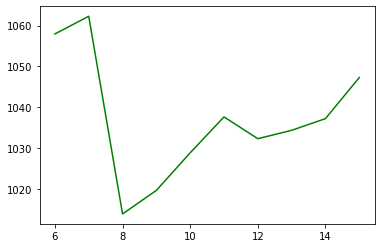

n_components with minimum perplexity: 8


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_perplexity(cv, start=10, end=30, max_iter=5, topic_word_prior= 0.1, 
                    doc_topic_prior=1.0):
    iter_num = []
    per_value = []

    for i in range(start, end + 1):
        lda = LatentDirichletAllocation(n_components = i, max_iter=max_iter, 
                                        topic_word_prior= topic_word_prior, 
                                        doc_topic_prior=doc_topic_prior,
                                        learning_method='batch', n_jobs= -1,
                                        random_state=7)    
        lda.fit(cv)
        iter_num.append(i)
        pv = lda.perplexity(cv)
        per_value.append(pv)
        print(f'n_components: {i}, perplexity: {pv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.show()
    return start + per_value.index(min(per_value))

print("n_components with minimum perplexity:",
      show_perplexity(review_cv, start=6, end=15))

In [12]:
lda = LatentDirichletAllocation(n_components = 8, #추출할 topic의 수를 지정
                                max_iter=20, 
                                topic_word_prior= 0.1, 
                                doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs= -1, 
                                random_state=7)

review_topics = lda.fit_transform(review_cv)

print_top_words(lda, cv.get_feature_names(), 10)

Topic #0: image, graphics, available, mail, file, ftp, data, files, information, software
Topic #1: posting, host, nntp, gov, university, nasa, com, distribution, ___, article
Topic #2: com, keith, article, morality, think, caltech, don't, sgi, objective, posting
Topic #3: com, article, know, jesus, just, don't, i'm, john, good, posting
Topic #4: people, god, does, don't, think, say, believe, just, way, like
Topic #5: drive, scsi, card, com, disk, ide, controller, bus, hard, use
Topic #6: space, nasa, access, launch, year, moon, article, just, digex, shuttle
Topic #7: key, encryption, clipper, chip, com, government, keys, use, security, public

